In [1]:
import numpy as np
from functools import partial
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

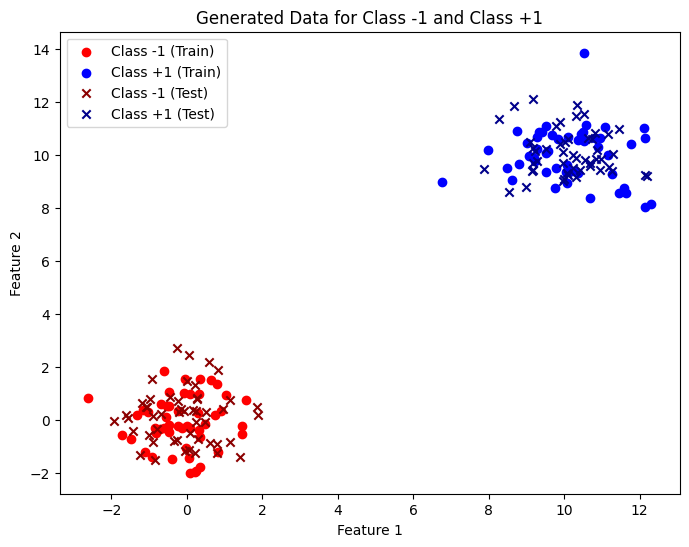

In [2]:
# Parameters for the normal distributions
mu1 = [0, 0]  # Mean for class -1
mu2 = [10, 10]  # Mean for class +1
sigma = np.eye(2)  # Identity matrix as the covariance matrix (σ = I)

np.random.seed(42)

# Generate 100 data points for each class
class_minus_1_train = np.random.multivariate_normal(mu1, sigma, 50)  # 50 points for training class -1
class_minus_1_test = np.random.multivariate_normal(mu1, sigma, 50)   # 50 points for testing class -1

class_plus_1_train = np.random.multivariate_normal(mu2, sigma, 50)   # 50 points for training class +1
class_plus_1_test = np.random.multivariate_normal(mu2, sigma, 50)    # 50 points for testing class +1

# Combine the training and test sets
X_synth_train = np.vstack((class_minus_1_train, class_plus_1_train))  # Training data
X_synth_test = np.vstack((class_minus_1_test, class_plus_1_test))    # Test data

# Create the corresponding labels for training and test sets
y_synth_train = np.concatenate((np.ones(50) * -1, np.ones(50)))  # Labels: -1 for class -1, +1 for class +1
y_synth_test = np.concatenate((np.ones(50) * -1, np.ones(50)))   # Labels for test data

# Optional: Plot the generated data to visualize the distribution
plt.figure(figsize=(8, 6))
plt.scatter(class_minus_1_train[:, 0], class_minus_1_train[:, 1], color='red', label='Class -1 (Train)')
plt.scatter(class_plus_1_train[:, 0], class_plus_1_train[:, 1], color='blue', label='Class +1 (Train)')
plt.scatter(class_minus_1_test[:, 0], class_minus_1_test[:, 1], color='darkred', label='Class -1 (Test)', marker='x')
plt.scatter(class_plus_1_test[:, 0], class_plus_1_test[:, 1], color='darkblue', label='Class +1 (Test)', marker='x')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Generated Data for Class -1 and Class +1')
plt.show()


In [3]:
def classify(X, y, maxitercnt=10000):
    rows, cols = X.shape
    nv = nw = 0
    v = w = np.zeros(cols + 1)
    itercnt = 0
    ones_column = np.ones((X.shape[0], 1))
    new_X = np.hstack((ones_column, X))
    np.random.seed(42)
    while itercnt <= maxitercnt:
        random_index = np.random.choice(rows)
        xj, yj = new_X[random_index], y[random_index]
        yhat = 1 if np.dot(v, xj) >= 0 else -1

        if yhat * yj > 0:
            nv += 1
        else:
            if nv > nw:
                w = v
                nw = nv
            
            v += yj * xj
            nv = 0
        
        itercnt += 1

    return w


def predict(X, weights):
    arr = np.dot(X, weights[1:]) + weights[0]
    return np.sign(arr)


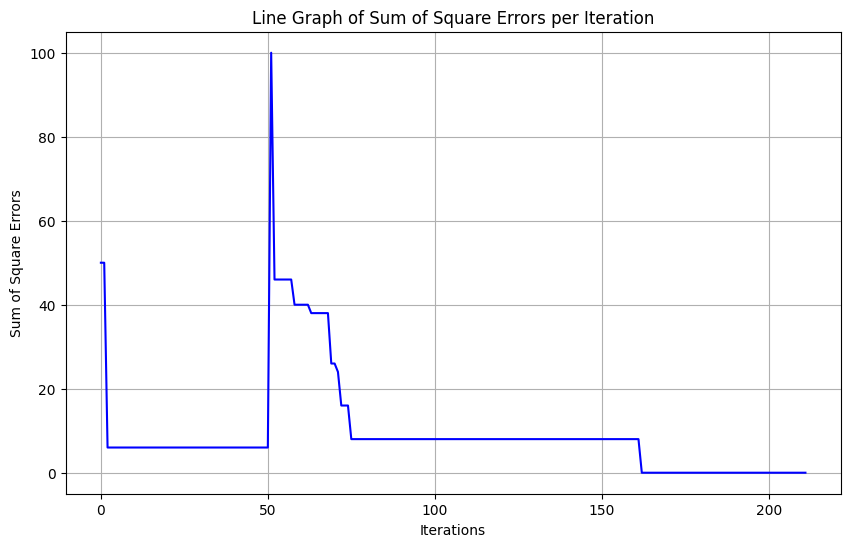

In [4]:
sses = []
for i in range(10000):
    w = classify(X_synth_train, y_synth_train, i)
    p = predict(X_synth_test, w)
    e = y_synth_test - p
    sse = 0.5 * np.dot(e, e)
    sses.append(sse)

    last_items = sses[-50:]
    if np.all(last_items == np.float64(0.0)):
        break


plt.figure(figsize=(10, 6))
plt.plot(range(len(sses)), sses, label="Feature1", color="blue", linestyle="-")
plt.title("Line Graph of Sum of Square Errors per Iteration")
plt.xlabel("Iterations")
plt.ylabel("Sum of Square Errors")
# plt.legend()
plt.grid(True)
plt.show()

#### Adaboost Construction and Evaluation

In [6]:
def adabtrain(X_train, y_train, k=100):
    rows, _ = X_train.shape
    weights = np.full(rows, 1/rows)
    alphas = []
    hypotheses = []
    for t in range(k):
        if t != 0:
            np.random.seed(t)
            resampled_indices = np.random.choice(
                np.arange(rows), size=rows, replace=True, p=weights)
            X_resampled = X_train[resampled_indices]
            y_resampled = y_train[resampled_indices]
        else:
            X_resampled, y_resampled = X_train, y_train

        w = classify(X_resampled, y_resampled)
        hypothesis = partial(predict, weights=w)
        hypotheses.append(hypothesis)
        prediction = hypothesis(X_train)

        # compute training error
        delta = (prediction != y_train).astype(int)
        epsilon = np.dot(weights, delta)

        # compute coefficient
        alpha = 0.5 * np.log((1 - epsilon) / epsilon)
        alphas.append(alpha)

        # compute the new weights
        single_wt_upd = weights * np.exp(-alpha * y_train * prediction)
        z = np.sum(single_wt_upd)
        weights = single_wt_upd / z

        # print(f'Weak learner accuracy: {accuracy(prediction, y_train)}')
        # print(f'Iteration {t}: Epsilon = {epsilon}')
        # print(f'Iteration {t}: Alpha = {alpha}')
        # print(f'Weights for iter {t}: {w}')
        # print(f'Sum of weights after normalization for iter {t}: {np.sum(weights)}')

    alphas = np.array(alphas)
    hypotheses = np.array(hypotheses)
    return alphas, hypotheses


def adabpredict(X_test, alphas, hypotheses):
    weak_preds = np.array([h(X_test) for h in hypotheses])  # Shape: (k, N_test)
    final_preds = np.sign(np.dot(alphas, weak_preds))  # Shape: (N_test,)
    return final_preds


def accuracy(y_pred, y_test):
    return (y_pred == y_test).astype(int).sum() / len(y_test)


In [15]:
banana = np.loadtxt('banana_data.csv', delimiter=',')
X_banana, y_banana = banana[:, 1:], banana[:, 0]
X_banana_train, X_banana_test, y_banana_train, y_banana_test = train_test_split(
    X_banana, y_banana, train_size=400, test_size=4900)

In [ ]:
banana_test_accuracies = []
banana_train_accuracies = []
for learners in range(10, 101, 10):
    print('===================================')
    print(f'Accuracy for {learners} learners')
    # print('===================================')
    banana_alphas, banana_hypotheses = adabtrain(
        X_banana_train, y_banana_train, learners)
    banana_train_pred = adabpredict(
        X_banana_train, banana_alphas, banana_hypotheses)
    banana_test_pred = adabpredict(
        X_banana_test, banana_alphas, banana_hypotheses)
    banana_train_accuracy = accuracy(banana_train_pred, y_banana_train)
    banana_test_accuracy = accuracy(banana_test_pred, y_banana_test)
    
    banana_train_accuracies.append(banana_train_accuracy)
    banana_test_accuracies.append(banana_test_accuracy)
    print(f'Training accuracy: {banana_train_accuracy}')
    print(f'Test accuracy: {banana_test_accuracy}')
    print('===================================')
    print(' ')


# Plot the banana accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(len(banana_test_accuracies)), banana_test_accuracies, label="Test Accuracy", color="blue", linestyle="-")
plt.plot(range(len(banana_train_accuracies)), banana_train_accuracies, label="Train Accuracy", color="orange", linestyle="--")
plt.title("Line Graph of Feature1 and Feature2 (Training Set)")
banana_indices = np.arange(len(banana_test_accuracies))
plt.xticks(banana_indices, (banana_indices + 1) * 10)
plt.xlabel("Learners")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

Accuracy for 10 learners
Training accuracy: 0.6825
Test accuracy: 0.6379591836734694
 
Accuracy for 20 learners
Training accuracy: 0.735
Test accuracy: 0.693469387755102
 
Accuracy for 30 learners
Training accuracy: 0.785
Test accuracy: 0.7783673469387755
 
Accuracy for 40 learners
Training accuracy: 0.8025
Test accuracy: 0.7918367346938775
 
Accuracy for 50 learners
Training accuracy: 0.805
Test accuracy: 0.7955102040816326
 
Accuracy for 60 learners
Training accuracy: 0.8
Test accuracy: 0.7936734693877551
 
Accuracy for 70 learners
Training accuracy: 0.81
Test accuracy: 0.8030612244897959
 
Accuracy for 80 learners
Training accuracy: 0.8125
Test accuracy: 0.7840816326530612
 
Accuracy for 90 learners
Training accuracy: 0.82
Test accuracy: 0.816530612244898
 
Accuracy for 100 learners
Training accuracy: 0.8425
Test accuracy: 0.8371428571428572
 


In [17]:
from sklearn.preprocessing import LabelEncoder
import imblearn
from collections import Counter

splice = np.loadtxt('splice_data.csv', delimiter=',')
X_splice, y_splice = splice[:, 1:], splice[:, 0]
y_splice_transformed = LabelEncoder().fit_transform(y_splice)
oversample = imblearn.over_sampling.SMOTE(random_state=42)
X_splice_smote, y_splice_smote = oversample.fit_resample(X_splice, y_splice)
X_splice_train, X_splice_test, y_splice_train, y_splice_test = train_test_split(
    X_splice_smote, y_splice_smote, train_size=1000, test_size=2175)

counter = Counter(y_splice_smote)
for k, v in counter.items():
    per = v / len(y_splice_smote) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=-1, n=1647 (50.000%)
Class=1, n=1647 (50.000%)


Accuracy for 10 learners
Training accuracy: 0.841
Test accuracy: 0.8188505747126437
 
Accuracy for 20 learners
Training accuracy: 0.842
Test accuracy: 0.8266666666666667
 
Accuracy for 30 learners
Training accuracy: 0.837
Test accuracy: 0.8248275862068966
 
Accuracy for 40 learners
Training accuracy: 0.844
Test accuracy: 0.8225287356321839
 
Accuracy for 50 learners
Training accuracy: 0.846
Test accuracy: 0.8266666666666667
 
Accuracy for 60 learners
Training accuracy: 0.846
Test accuracy: 0.8220689655172414
 
Accuracy for 70 learners
Training accuracy: 0.847
Test accuracy: 0.8225287356321839
 
Accuracy for 80 learners
Training accuracy: 0.845
Test accuracy: 0.8239080459770115
 
Accuracy for 90 learners
Training accuracy: 0.846
Test accuracy: 0.825287356321839
 
Accuracy for 100 learners
Training accuracy: 0.847
Test accuracy: 0.8257471264367816
 


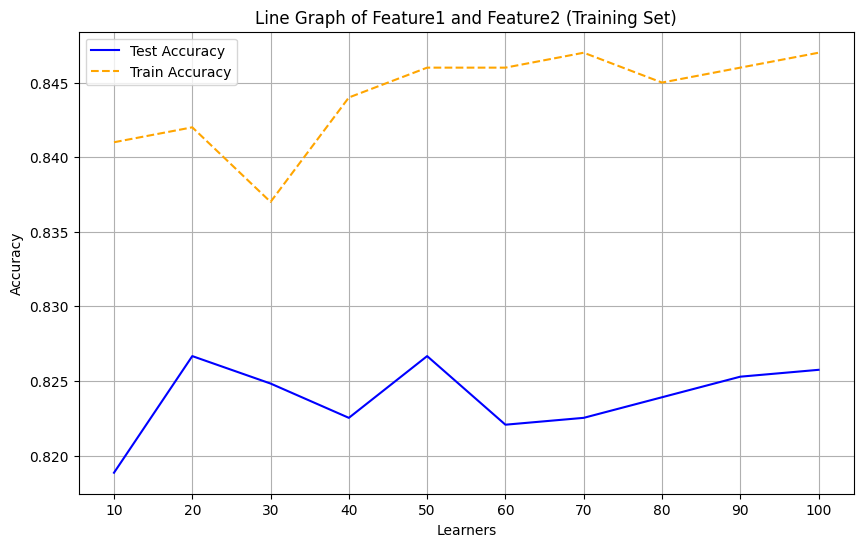

In [18]:
splice_test_accuracies = []
splice_train_accuracies = []
for learners in range(10, 101, 10):
    print('===================================')
    print(f'Accuracy for {learners} learners')
    # print('===================================')
    splice_alphas, splice_hypotheses = adabtrain(
        X_splice_train, y_splice_train, learners)
    splice_train_pred = adabpredict(
        X_splice_train, splice_alphas, splice_hypotheses)
    splice_test_pred = adabpredict(
        X_splice_test, splice_alphas, splice_hypotheses)
    splice_train_accuracy = accuracy(splice_train_pred, y_splice_train)
    splice_test_accuracy = accuracy(splice_test_pred, y_splice_test)
    
    splice_train_accuracies.append(splice_train_accuracy)
    splice_test_accuracies.append(splice_test_accuracy)
    print(f'Training accuracy: {splice_train_accuracy}')
    print(f'Test accuracy: {splice_test_accuracy}')
    print('===================================')
    print(' ')


# Plot the splice accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(len(splice_test_accuracies)), splice_test_accuracies, label="Test Accuracy", color="blue", linestyle="-")
plt.plot(range(len(splice_train_accuracies)), splice_train_accuracies, label="Train Accuracy", color="orange", linestyle="--")
plt.title("Line Graph of Feature1 and Feature2 (Training Set)")
splice_indices = np.arange(len(splice_test_accuracies))
plt.xticks(splice_indices, (splice_indices + 1) * 10)
plt.xlabel("Learners")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()